<a href="https://colab.research.google.com/github/kathmandu777/Research-Floodit/blob/master/FloodIt_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FloodIt 深層強化学習

## 共通設定


In [1]:
from google.colab import drive
drive.mount('/content/drive')

root_dir='/content/drive/MyDrive/Colab Notebooks/FloodIt new' #colabのGoogleDriveの位置

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%load_ext tensorboard

## gym環境

参考文献(gym環境の構築方法)  
- https://stable-baselines.readthedocs.io/en/master/guide/custom_env.html
- https://qiita.com/inoory/items/e63ade6f21766c7c2393
- https://qiita.com/harmegiddo/items/4226df13139d6ba34018
- https://qiita.com/ohtaman/items/edcb3b0a2ff9d48a7def
- https://moriokalab.com/news/57
- https://qiita.com/inoory/items/e63ade6f21766c7c2393
- https://ailog.site/2020/05/06/0506/
- https://note.com/npaka/n/nc90b305f4ca0
- https://qiita.com/pocokhc/items/a8120b0abd5941dd7a9f
- https://kagglenote.com/ml-tips/my-environment-with-gym/
- https://qiita.com/YudaiSadakuni/items/09e111bec5de257a5782
- https://kagglenote.com/ml-tips/my-environment-with-gym/
- https://omedstu.jimdofree.com/2018/05/30/openai-gym%E3%81%A7%E3%82%AA%E3%83%AA%E3%82%B8%E3%83%8A%E3%83%AB%E3%81%AE%E7%92%B0%E5%A2%83%E3%82%92%E4%BD%9C%E3%82%8B/


In [2]:
!pip install pygame
!pip install gym

import gym
from gym import error, spaces, utils
from gym.utils import seeding
import random
import copy
import numpy as np
import pygame
import os
from pygame.locals import *

pygame 2.0.1 (SDL 2.0.14, Python 3.7.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
# 各種グローバル変数
SMALLBOXSIZE = 60  # size is in pixels
MEDIUMBOXSIZE = 20
LARGEBOXSIZE = 11

SMALLBOARDSIZE = 6  # size is in boxes
MEDIUMBOARDSIZE = 17
LARGEBOARDSIZE = 30

SMALLMAXLIFE = 10  # number of turns
MEDIUMMAXLIFE = 30
LARGEMAXLIFE = 64

FPS = 60
WINDOWWIDTH = 640
WINDOWHEIGHT = 480
PALETTEGAPSIZE = 10
PALETTESIZE = 45
EASY = 0   # arbitrary but unique value
MEDIUM = 1  # arbitrary but unique value
HARD = 2   # arbitrary but unique value


#          R    G    B
WHITE = (255, 255, 255)
DARKGRAY = (70,  70,  70)
BLACK = (0,   0,   0)
RED = (255,   0,   0)
GREEN = (0, 255,   0)
BLUE = (0,   0, 255)
YELLOW = (255, 255,   0)
ORANGE = (255, 128,   0)
PURPLE = (255,   0, 255)

# The first color in each scheme is the background color, the next six are the palette colors.
COLORSCHEMES = (((150, 200, 255), RED, GREEN, BLUE, YELLOW, ORANGE, PURPLE),
                ((0, 155, 104),  (97, 215, 164),  (228, 0, 69),  (0, 125, 50),
                 (204, 246, 0),   (148, 0, 45),    (241, 109, 149)),
                ((195, 179, 0),  (255, 239, 115), (255, 226, 0), (147, 3, 167),
                 (24, 38, 176),   (166, 147, 0),   (197, 97, 211)),
                ((85, 0, 0),     (155, 39, 102),  (0, 201, 13),  (255, 118, 0),
                 (206, 0, 113),   (0, 130, 9),     (255, 180, 115)),
                ((191, 159, 64), (183, 182, 208), (4, 31, 183),  (167, 184, 45),
                 (122, 128, 212), (37, 204, 7),    (88, 155, 213)),
                ((200, 33, 205), (116, 252, 185), (68, 56, 56),  (52, 238, 83),  (23, 149, 195),  (222, 157, 227), (212, 86, 185)))

# 色の設定 ※気にしなくてよい エラー表示専用
"""
for i in range(len(COLORSCHEMES)):
    assert len(
        COLORSCHEMES[i]) == 7, 'Color scheme %s does not have exactly 7 colors.' % (i)
bgColor = COLORSCHEMES[0][0]
paletteColors = COLORSCHEMES[0][1:]
"""
bgColor = COLORSCHEMES[0][0]
paletteColors = COLORSCHEMES[0][1:]


In [37]:
class FlooditEnv(gym.Env):
    def __init__(self,ignore_same_action=False,not_learning=False):
        super(FlooditEnv, self).__init__()

        # アクションの数の設定
        self.action_space = gym.spaces.Discrete(6)

        # 状態空間の設定, 観測空間(state)の次元
        # (e.g.)状態が3つの時で、それぞれの状態が正規化されている場合、LOW=[0,0,0]、HIGH=[1,1,1]
        MAP = np.array([[0] * 6 for _ in range(6)])
        self.observation_space = gym.spaces.Box(low=0, high=5, shape=MAP.shape)

        self.ignore_same_action = ignore_same_action
        self.not_learning=not_learning

        self.reset()

    def reset(self):
        # シミュレータの初期化処理

        # デフォルトのゲームの難易度
        self.difficulty = EASY
        self.maxLife = SMALLMAXLIFE
        self.boardWidth = SMALLBOARDSIZE
        self.boardHeight = SMALLBOARDSIZE
        self.boxSize = SMALLBOXSIZE

        # 盤面とライフの初期化
        self.mainBoard = self.generateRandomBoard(
            self.boardWidth, self.boardHeight, self.difficulty)
        self.life = self.maxLife
        self.lastAction = None
        self.continueing_square = 0


        
        info = {"isWon": False, "isLose": False,
                "changed_square": None, "life": self.life,"is_same_action":False}

        if(self.not_learning):
          return self.mainBoard ,info
        else:
          return self.mainBoard

    def step(self, action):
        isWon = False
        isLose = False
        done = False
        is_same_action=False
        reward = 0.0

        changed_square = self.flood_and_count(self.mainBoard, action)
        if (changed_square == 0):
            reward = -0.5
            if (self.ignore_same_action):  # レンダリング中は同じ手を選んでも無視する
                pass
            else:
                done = True
                is_same_action=True
        else:
            reward = changed_square/36
        self.life -= 1

        # 勝利or敗北時の描画
        if self.hasWon(self.mainBoard):
            reward = 1
            done = True
            isWon = True
            
        elif self.life == 0:
            reward = -1
            done = True
            isLose = True
            

        info = {"isWon": isWon, "isLose": isLose,
                "changed_square": changed_square, "life": self.life,"is_same_action":is_same_action}
        #info = {"isWon": isWon, "isLose": isLose,"changed_square": changed_square, "life": self.life, "isQuit": self.checkReset()}

        return np.array(self.mainBoard), reward, done, info

    def flood_and_count(self, board, action, animationSpeed=25):  # マスを選択された色に変換し、変更マス数を返す
        origBoard = copy.deepcopy(board)

        # 先頭の色が連続しているマスの数を数える
        self.continueing_square = 0
        self.countSquare(copy.deepcopy(board), board[0][0], 0, 0)
        self.before_continueing_square = self.continueing_square

        # マスを選択された色に変換
        self.floodFill(board, board[0][0], action, 0, 0)

        # 先頭の色が連続しているマスの数を数える
        self.continueing_square = 0
        self.countSquare(copy.deepcopy(board), board[0][0], 0, 0)
        self.after_continueing_square = self.continueing_square

        return self.after_continueing_square - self.before_continueing_square

    def floodFill(self, board, oldColor, newColor, x, y):  # マスの色を選択された色に変更
        if oldColor == newColor or board[x][y] != oldColor:
            # 先頭のマスの色と選択された色が同じ or 検索しているマスが先頭のマスと違う色だったら
            return

        board[x][y] = newColor  # change the color of the current box

        # Make the recursive call for any neighboring boxes:
        if x > 0:
            self.floodFill(board, oldColor, newColor, x - 1, y)
        if x < self.boardWidth - 1:
            self.floodFill(board, oldColor, newColor, x + 1, y)
        if y > 0:
            self.floodFill(board, oldColor, newColor, x, y - 1)
        if y < self.boardHeight - 1:
            self.floodFill(board, oldColor, newColor, x, y + 1)

    def countSquare(self, board, originColor, x, y):  # 先頭の色と連続した色のマスのカウント
        if (board[x][y] != originColor or board[x][y] == -1):
            # マスの色が原点のマスの色と異なる or 探索済み
            return

        board[x][y] = -1  # 探索済みの印

        self.continueing_square += 1

        if x > 0:
            self.countSquare(board, originColor, x - 1, y)
        if x < self.boardWidth - 1:
            self.countSquare(board, originColor, x + 1, y)
        if y > 0:
            self.countSquare(board, originColor, x, y - 1)
        if y < self.boardHeight - 1:
            self.countSquare(board, originColor, x, y + 1)

    def hasWon(self, board):  # 勝ったかどうか＝＝全マス同じ色か
        for x in range(self.boardWidth):
            for y in range(self.boardHeight):
                if board[x][y] != board[0][0]:
                    return False  # found a different color, player has not won
        return True

    def generateRandomBoard(self, width, height, difficulty=MEDIUM):  # 盤面の初期化
        # Creates a board data structure with random colors for each box.
        board = []
        for x in range(width):
            column = []
            for y in range(height):
                column.append(random.randint(0, len(paletteColors) - 1))
            board.append(column)

        # Make board easier by setting some boxes to same color as a neighbor.

        # Determine how many boxes to change.
        if difficulty == EASY:
            if self.boxSize == SMALLBOXSIZE:
                boxesToChange = 100
            else:
                boxesToChange = 1500
        elif difficulty == MEDIUM:
            if self.boxSize == SMALLBOXSIZE:
                boxesToChange = 5
            else:
                boxesToChange = 200
        else:
            boxesToChange = 0

        # Change neighbor's colors:
        for i in range(boxesToChange):
            # Randomly choose a box whose color to copy
            x = random.randint(1, width-2)
            y = random.randint(1, height-2)

            # Randomly choose neighbors to change.
            direction = random.randint(0, 3)
            if direction == 0:  # change left and up neighbor
                board[x-1][y] = board[x][y]
                board[x][y-1] = board[x][y]
            elif direction == 1:  # change right and down neighbor
                board[x+1][y] = board[x][y]
                board[x][y+1] = board[x][y]
            elif direction == 2:  # change right and up neighbor
                board[x][y-1] = board[x][y]
                board[x+1][y] = board[x][y]
            else:  # change left and down neighbor
                board[x][y+1] = board[x][y]
                board[x-1][y] = board[x][y]
        return board

    def quit(self):
        pygame.quit()

## 実行確認

In [28]:
import cv2
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np

from IPython.display import HTML
from matplotlib.colors import ListedColormap
import math
import matplotlib


In [29]:
# プレイの様子を動画で見てみるための関数
#　https://pystyle.info/matplotlib-master-of-colormap/

def display_video(frames):
    plt.figure(figsize=(8, 8), dpi=50)

    # 色変換
    colors=["red","blue","green","yellow","orange","purple","white","black","cyan"]
    cmap=ListedColormap(colors)
    cmap.set_under("darkred")  # 0より小さい値
    cmap.set_over("darkblue")  # 4より大きい値
    cmap.set_bad("yellow")  # 無効な値
    patch = plt.imshow(frames[0],cmap=cmap,vmin = 0, vmax = len(colors))
    plt.axis('off')
    
    def animate(i):
        patch.set_data(frames[i])
    
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=200)
    display(HTML(anim.to_jshtml(default_mode='once')))
    plt.close()

In [30]:
# 環境を描画形式の配列に（ライフの描画,勝敗の描画）
def obs_to_frame(obs,info,maxlife):
  #情報(win,lose,done)可視化
  info_list=[]
  
  if(info["isWon"]):
    info_list.append([0]*(len(obs)*3))#赤色の行
  elif(info["isLose"]):
    info_list.append([1]*(len(obs)*3))#青色の行
  elif(info["is_same_action"]):
    info_list.append([7]*(len(obs)*3))#黒色の行
  else:
    info_list.append([6]*(len(obs)*3))#白色の行
  
  info_list.append([6]*(len(obs)*3))#マージン

  #環境可視化
  new_obs=[]

  for i in range(len(obs)):
    new_obs.append([])
    for j in range(len(obs[0])):
      new_obs[i*3].append(obs[i][j])
      new_obs[i*3].append(obs[i][j])
      new_obs[i*3].append(obs[i][j])
    new_obs.append(new_obs[i*3])
    new_obs.append(new_obs[i*3])

  new_obs.append([6]*(len(obs)*3))#マージン
  
  padding=len(obs)*3-maxlife
  life_list=[6]*math.floor(padding/2) # white
  life_list+=[7]*(maxlife-info["life"]) 
  life_list+=[8]*info["life"] #残ライフ
  life_list+=[6]*math.ceil(padding/2) # white
  new_obs.append(life_list) 

  frame=info_list+new_obs
  
  return frame

In [38]:
env = FlooditEnv(not_learning=True)
#env = FlooditEnv(ignore_same_action=True)

obs,info = env.reset()
frames = []
total_reward = 0
done = False
maxlife=info["life"]

for i in range(30):
    frames.append(obs_to_frame(obs,info,maxlife))
    action = env.action_space.sample()  # 行動空間から一様ランダムに行動をサンプル
    next_obs, reward, done, info = env.step(action)
    total_reward += reward
    obs = next_obs
    if done:
      frames.append(obs_to_frame(obs,info,maxlife))
      obs,info=env.reset()


print('TotalReward: ', total_reward)
display_video(frames)


TotalReward:  -11.72222222222222


## 学習

In [ ]:
"""
!pip install keras==2.2.4
!pip install keras-rl==0.4.2
!pip install tensorflow==1.13.1
!pip install tensorflow-gpu==1.13.1
==> len is not well defined for symbolic Tensors. (DQNAgent)

!pip install keras==2.2.4
!pip install keras-rl==0.4.2
!pip install tensorflow==2.4.0
!pip install tensorflow-gpu==2.4.0
==> len is not well defined for symbolic Tensors. (DQNAgent)

!pip install keras==2.2.4
!pip install keras-rl==0.4.2
!pip install tensorflow==1.15.2
!pip install tensorflow-gpu==1.15.2
==>len is not well defined for symbolic Tensors.

!pip install keras==2.2.4
!pip install keras-rl==0.4.2
!pip install tensorflow==2.0.0-beta
!pip install tensorflow-gpu==2.0.0-beta
==>len is not well defined for symbolic Tensors.

# conda環境と同じ
!pip install keras==2.3.1
!pip install keras-rl==0.4.2
!pip install tensorflow==1.14.0
!pip install tensorflow-gpu==1.14.0
==> 'Tensor' object has no attribute '_keras_shape'
"""



!pip install tensorflow==2.3.0
!pip install gym
!pip install keras
!pip install keras-rl2

In [35]:


import matplotlib.pyplot as plt
import rl.callbacks

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory

import sys
import datetime
import gym
import numpy as np
from tensorflow.python.keras.utils.vis_utils import plot_model
import os
from rl.callbacks import FileLogger, ModelIntervalCheckpoint
from tensorflow.keras.callbacks import TensorBoard

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


action_space      : Discrete(6)
observation_space : Box(0.0, 5.0, (6, 6), float32)
reward_range      : (-inf, inf)

**************************************************  Model  **************************************************

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 36)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                2368      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_30 (Dense)             (None, 6)                 390       
Total params: 6,918
Trai

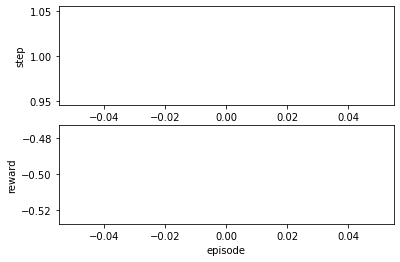


**************************************************  Test  **************************************************

Testing for 10 episodes ...
Episode 1: reward: -0.500, steps: 1
Episode 2: reward: -0.500, steps: 1
Episode 3: reward: -0.500, steps: 1
Episode 4: reward: -0.500, steps: 1
Episode 5: reward: 0.333, steps: 2
Episode 6: reward: -0.500, steps: 1
Episode 7: reward: -0.056, steps: 2
Episode 8: reward: -0.500, steps: 1
Episode 9: reward: -0.417, steps: 2
Episode 10: reward: 0.417, steps: 2


In [39]:
env = FlooditEnv()
print("action_space      : " + str(env.action_space))
print("observation_space : " + str(env.observation_space))
print("reward_range      : " + str(env.reward_range))

nb_actions = env.action_space.n
now_time = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
os.makedirs(os.path.join(root_dir,"result/DQN/"+now_time))
os.makedirs(os.path.join(root_dir,"result/DQN/"+now_time+"/checkpoints"))


model = Sequential()    
model.add(Flatten(input_shape=(1,)+env.observation_space.shape))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(nb_actions, activation='softmax'))

print()
print("*"*50+"  Model  "+"*"*50)
print()
print(model.summary())
plot_model(model, to_file=os.path.join(root_dir,"result/DQN/"+str(now_time) +
           "/DQN_model.png"), show_shapes=True)


# DQN agentの定義
memory = SequentialMemory(limit=50000, window_length=1,
                          ignore_episode_boundaries=True)
policy = EpsGreedyQPolicy(eps=0.1)
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=100,target_model_update=1e-2, policy=policy)
# Adam._name = 'fake_name_for_error'
dqn.compile(Adam(lr=1e-3), metrics=['mae'])


# 学習
print()
print("*" * 50 + "  History  " + "*" * 50)

MAX_STEPS = 100  # 学習ステップ回数

checkpoint_weights_filename = os.path.join(root_dir,"result/DQN/"+ \
    str(now_time) + "/checkpoints/weights_{step}steps.h5f")
logdir = os.path.join(root_dir,"result/DQN/" + str(now_time))

# モデルを保存する頻度
callbacks = [ModelIntervalCheckpoint(
    checkpoint_weights_filename, interval=100000)]
# logをとる頻度(なし?)
callbacks += [TensorBoard(log_dir=logdir)]

history = dqn.fit(env, nb_steps=MAX_STEPS, visualize=False,
                  verbose=1)


# 重みの保存
dqn.save_weights(os.path.join(root_dir,"result/DQN/"+str(now_time) +"/weights_final.h5f"), overwrite=False)


# グラフを表示
# 1エピソードのstep試行回数
plt.subplot(2, 1, 1)
x = []
y = []
for i in range(len(history.history["nb_episode_steps"])):
    if(i % 1000 == 0):
        x.append(i)
        y.append(history.history["nb_episode_steps"][i])
plt.plot(x, y)
plt.ylabel("step")

# 1エピソードの報酬
plt.subplot(2, 1, 2)
x = []
y = []
for i in range(len(history.history["episode_reward"])):
    if(i % 1000 == 0):
        x.append(i)
        y.append(history.history["episode_reward"][i])
plt.plot(x, y)
plt.ylabel("reward")

plt.xlabel("episode")
plt.savefig(os.path.join(root_dir,"result/DQN/" + now_time + str("/step-reward_plt.jpg")))
plt.show()


#dqn.load_weights(os.path.join(root_dir,"result/DQN/20210224_204442/weights_final.h5f"))

# 学習結果のテスト
print()
print("*"*50+"  Test  "+"*"*50)
print()
dqn.test(env, nb_episodes=10, visualize=False)
